#**Loans_ML_Project**

##**Data Dictionary:**

**Column Name** ---------------	**Description**

1.  loan_id	Unique ---------------- loan ID
2.  gender	---------------------------- Gender - Male / Female
3.  married	--------------------------- Marital status - Yes / No
4.  dependents	--------------------- Number of dependents
5.  education	------------------------ Education - Graduate / Not Graduate
6.  self_employed	----------------- Self-employment status - Yes / No
7.  applicant_income	------------ Applicant's income
8.  coapplicant_income --------	Coapplicant's income
9.  loan_amount	-------------------- Loan amount (thousands)
10. loan_amount_term -----------	Term of loan (months)
11. credit_history	------------------- Credit history meets guidelines - 1 / 0
12. property_area	------------------- Area of the property - Urban / Semi Urban / Rural
13. loan_status	---------------------- Loan approval status (target) - 1 / 0

**GOAL: Create a model to analyze loans.**

##**Packages Importation and Data Loading**

In [1]:
# NumPy for numerical operations, especially with arrays
import numpy as np

# pandas for handling and analyzing tabular data
import pandas as pd

# matplotlib for basic plotting functions
import matplotlib.pyplot as plt

# seaborn for advanced plotting functions
import seaborn as sns

# Mount Google Drive (for Google Colab users) to load/save files
from google.colab import drive

# Import encoders for converting categorical data into numbers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Import test for checking if data follows a normal distribution
from scipy.stats import normaltest

# Import common scalers to normalize numerical data (Standard, Min-Max, Robust)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# For splitting data into training and testing sets
from sklearn.model_selection import train_test_split

# Import logistic regression model (good for binary classification)
from sklearn.linear_model import LogisticRegression

# Import Random Forest classifier (alternative to LogisticRegression)
from sklearn.ensemble import RandomForestClassifier

# SMOTE helps to balance datasets by creating synthetic examples of the minority class
from imblearn.over_sampling import SMOTE

# Common evaluation metrics for classification problems
from sklearn.metrics import (accuracy_score,      # how often is the classifier correct
                             precision_score,     # how many selected items are relevant
                             recall_score,        # how many relevant items are selected
                             f1_score,            # balance between precision and recall
                             confusion_matrix,    # shows true/false positives/negatives
                             classification_report, # summary of all classification metrics
                             roc_auc_score,         # measures the quality of binary classification
                             roc_curve,             # plots the roc_auc_score
                             auc
                            )

# GridSearchCV helps find the best parameters for your model by testing many combinations
from sklearn.model_selection import GridSearchCV


In [2]:
# Mount your Google Drive to access files from it (needed when using Google Colab)
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# List the contents of the folder "Finale_Mock_Interview" inside "MyDrive"
!ls /content/drive/MyDrive/Finale_Mock_Interview/

loans.csv  loans.gsheet


In [4]:
# Load the CSV file 'loans.csv' from your Google Drive into a pandas DataFrame called df
df = pd.read_csv('/content/drive/MyDrive/Finale_Mock_Interview/loans.csv')

##**Dataset Inspection:**

In [5]:
df.head()

,loan_id,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status
0,LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,0.0
1,LP001005,Male,Yes,0,Graduate,NaN,3000.0,0.0,66.0,360.0,1.0,Urban,1.0
2,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,1.0
3,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,1.0
4,LP001011,Male,Yes,2,Graduate,Yes,5417.0,4196.0,267.0,360.0,1.0,Urban,1.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loan_id             534 non-null    object 
 1   gender              534 non-null    object 
 2   married             544 non-null    object 
 3   dependents          531 non-null    object 
 4   education           541 non-null    object 
 5   self_employed       529 non-null    object 
 6   applicant_income    537 non-null    float64
 7   coapplicant_income  529 non-null    float64
 8   loan_amount         533 non-null    float64
 9   loan_amount_term    535 non-null    float64
 10  credit_history      541 non-null    float64
 11  property_area       542 non-null    object 
 12  loan_status         535 non-null    float64
dtypes: float64(6), object(7)
memory usage: 57.3+ KB


In [7]:
# Since credit_history isn't a fully numurical col, it's better to make it fully categorical and then encode it.
df['credit_history'] = df['credit_history'].astype(object)

# Same thing with loan_status and moreover, it's the target(0 and 1 represent the 2 classes we have in that col).
df['loan_status'] = df['loan_status'].astype(object)

In [8]:
display(df["gender"].unique())          # We have 2 types of gender by now but we can other types in in th future --> OneHotEncoder.
display(df["married"].unique())         # We have 2 types of marital status(which is normal). No inerent order amoung them  --> OneHotEncoder.
display(df["dependents"].unique())      # We clearly have the inerent order here --> LabelEncoder. Since we can not convert it in int.
display(df["education"].unique())       # Either Graduated or not: LabelEncoder.
display(df["self_employed"].unique())   # No inerent order amoung them  --> OneHotEncoder.
display(df["credit_history"].unique())  # No inerent order amoung them  --> OneHotEncoder.
display(df["property_area"].unique())   # No inerent order amoung them  --> OneHotEncoder.
display(df["loan_status"].unique())     # No inerent order amoung them  --> OneHotEncoder.

array(['Male', 'Female', nan], dtype=object)

array(['Yes', 'No', nan], dtype=object)

array(['1', '0', '2', '3+', nan], dtype=object)

array(['Graduate', 'Not Graduate', nan], dtype=object)

array(['No', nan, 'Yes'], dtype=object)

array([1.0, 0.0, nan], dtype=object)

array(['Rural', 'Urban', nan, 'Semiurban'], dtype=object)

array([0.0, 1.0, nan], dtype=object)

##**EDA**

###**Descriptive Statistics**

In [9]:
# Getting the summary statistic of df's numerical columns(include defaults to None).
df.describe()

,applicant_income,coapplicant_income,loan_amount,loan_amount_term
count,537.000000,529.000000,533.000000,535.000000
mean,5379.370577,1692.604764,147.433396,341.674766
std,6064.809533,3093.379309,85.851735,65.301425
min,150.000000,0.000000,9.000000,12.000000
25%,2894.000000,0.000000,100.000000,360.000000
50%,3762.000000,1250.000000,128.000000,360.000000
75%,5818.000000,2333.000000,172.000000,360.000000
max,81000.000000,41667.000000,650.000000,480.000000


In [10]:
# duplicated() --> map of boolean value and sum() --> total number(False=0; True=1) of duplicate for each column.
df.duplicated().sum()

np.int64(25)

In [11]:
# Dropping the fully duplicated rows.
df_wt_duplicat = df.drop_duplicates()

# duplicated() --> map of boolean value and sum() --> total number(False=0; True=1) of duplicate for each column.
df_wt_duplicat.duplicated().sum()

np.int64(0)

In [12]:
# isna() --> map of boolean value and mean() -->  sum(True)/count(datapoint) columnwise.
df_wt_duplicat.isna().mean().sort_values(ascending=False) * 100

,0
self_employed,5.947955
coapplicant_income,5.947955
loan_amount,5.576208
dependents,5.576208
loan_status,5.204461
gender,5.018587
loan_id,4.832714
loan_amount_term,4.646840
applicant_income,4.460967
credit_history,4.089219


###**Graphical EDA**

In [13]:
# Selecting the numerical columns
num_columns = df_wt_duplicat.select_dtypes(include = np.number).columns
num_columns

Index(['applicant_income', 'coapplicant_income', 'loan_amount',
       'loan_amount_term'],
      dtype='object')

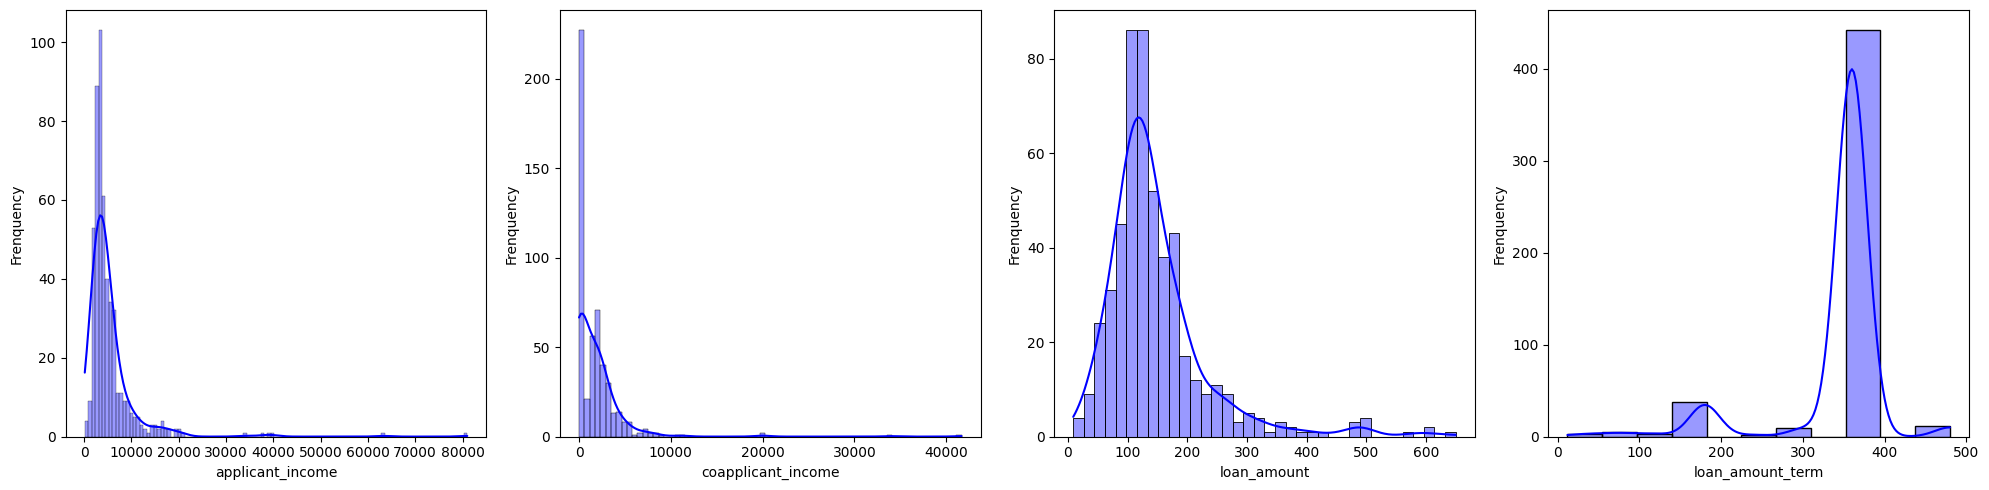

In [14]:
# Plotting the numerical columns in histogram

fig, axes = plt.subplots(1, 4, figsize=(20, 5))       # axes here is a 2D array.
sns.set_style("darkgrid")                             # Setting the background style to "darkgrid".
axes = axes.flatten()                                 # By flattening the axes, we convert it in an 1D array such that it can be iterable.
for i, col in enumerate(num_columns):                 # enumerate allows us to iterate with i through axes and col through num_columns.
  g = sns.histplot(                                   # By assigning the plot to a variable(g) we have more control over it.
                   df_wt_duplicat,                         # Passing the dataset.
                   x = col,                           # Passing the column we want to plot.
                   kde = True,                        # By setting the Kernel Density Estimate parameter to True, the chart will contain a smoothed curve.
                   ax = axes[i],                      # We're asking python to plot the col in the i-th subplot(axes[i])
                   color = "b",                       # Setting the color to blue.
                   edgecolor= "black",                # Setting the edge color to black.
                   alpha = 0.4                        # Setting the parameter or argument alpha(transparency) = 0.4.
                  )
  g.set(xlabel=col, ylabel="Frenquency")              # Setting the x and y label.
plt.tight_layout()                                    # Adjust layout to prevent label cutoff.
plt.show()                                            # Showing the plot.

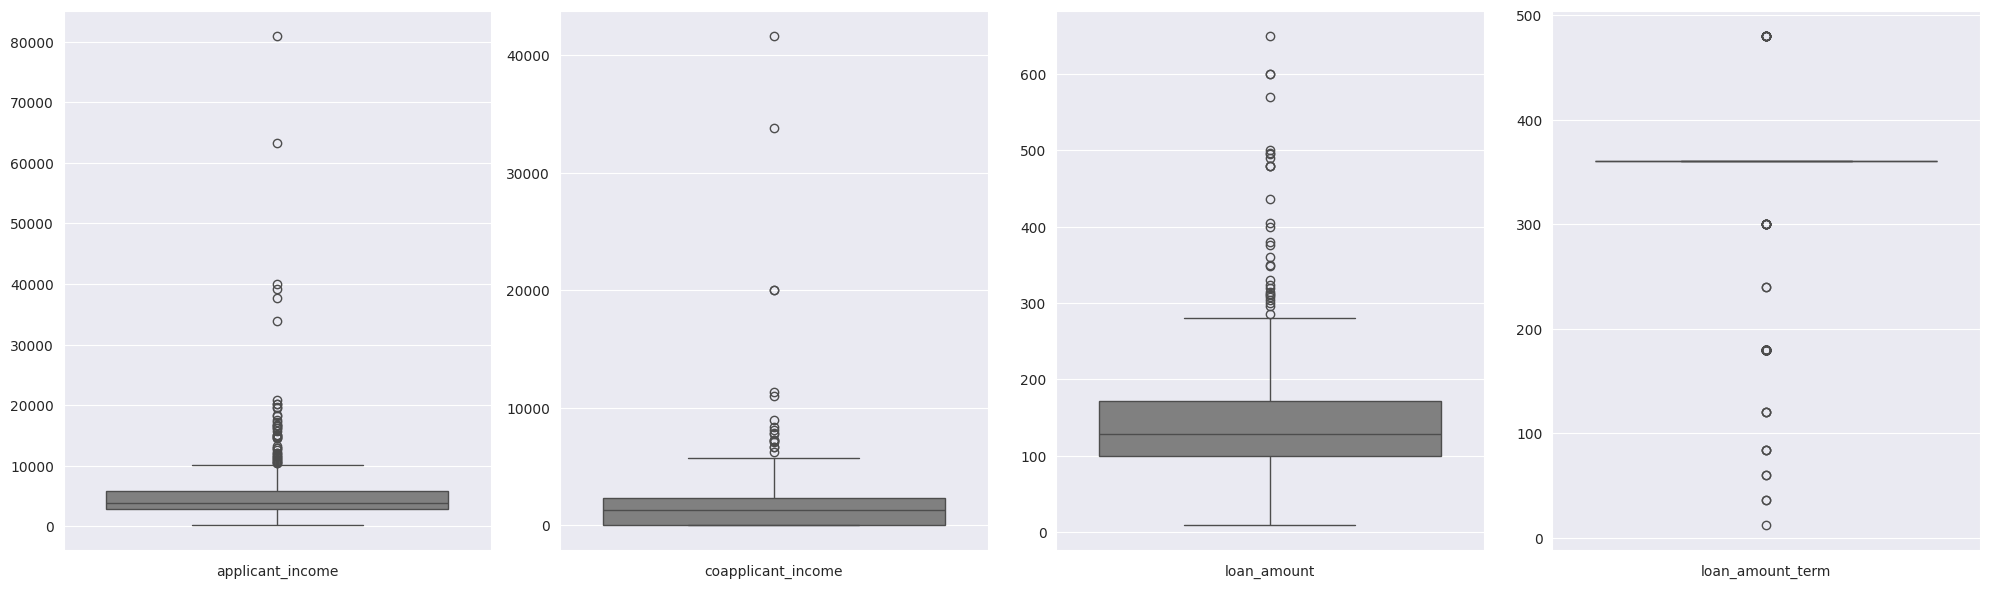

In [15]:
# Plotting the numerical columns in boxplot

fig, axes = plt.subplots(1, 4, figsize=(20, 6))       # axes here is a 2D array.
sns.set_style("ticks")                                # Setting the background style to "darkgrid".
axes = axes.flatten()                                 # By flattening the axes, we convert it in an 1D array such that it can be iterable.
for i, col in enumerate(num_columns):                 # enumerate allows us to iterate with i through axes and col through num_columns.
  g = sns.boxplot(                                    # By assigning the plot to a variable(g) we have more control over it.
                   df_wt_duplicat,                        # Passing the dataset.
                   y = col,                           # Passing the column ww want to plot.
                   ax = axes[i],                      # We're asking python to plot the col in the i-th subplot(axes[i])
                   color = "gray",                    # Setting the color to blue.
                  )
  g.set(xlabel=col, ylabel='')                        # Setting the x and y label.
plt.tight_layout()                                    # Adjust layout to prevent label cutoff.
plt.show()                                            # Showing the plot.

In [16]:
# Selecting the columns with outliers
col_to_cap = ['applicant_income', 'coapplicant_income', 'loan_amount','loan_amount_term']

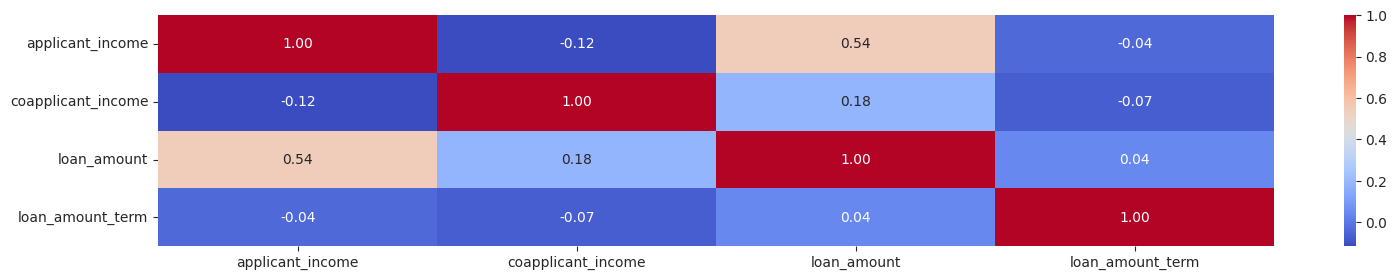

In [17]:
# plotting the correlation matrix of the numerical columns.

matrix_corr = df_wt_duplicat[num_columns].corr()          # Computing the correlation matrix of the numerical columns.
fig = plt.figure(figsize=(18,3))                      # Setting the figure size.
sns.heatmap(                                          # Plotting the heatmap of the matrix corelation.
            matrix_corr,                              # Passing the matrix_corr
            annot = True,                             # When set to True, annot allows us to display to values in the matrix correlation.
            fmt=".2f",                                # rounding the values to 2 figures after the dut.
            cmap="coolwarm"                           # Passing the coolwarm value as the map color.
            )
plt.show()                                            # Showing the plot.

##**Data Preprocessing For ML**

###**Step 1: Missing Values Handling.**  

In [18]:
# dropna in loan_id to avoid duplicates, set loan_id as inndex and check for mna in all the other columns

df_na = df_wt_duplicat.copy().dropna(subset = {"loan_id"}, inplace = False)
df_na = df_na.set_index('loan_id')
df_na.isna().mean().sort_values(ascending=False) * 100

,0
coapplicant_income,6.250000
self_employed,5.859375
dependents,5.664062
loan_amount,5.468750
loan_status,5.078125
gender,4.882812
applicant_income,4.492188
loan_amount_term,4.492188
credit_history,3.906250
education,3.906250


In [19]:
# Define a function that automatically fills missing values in a DataFrame

def fill_auto(df):

    # Loop through each column in the DataFrame
    for col in df.columns:

        # Check if the column has any missing values (NaNs)
        if df[col].isna().sum() > 0:

            # If the column is made of numbers (integers or floats)
            if df[col].dtype in ['float64', 'int64']:

                # Check if the distribution is close to symmetric (not skewed)
                if abs(df[col].skew()) < 0.5:
                    # If so, fill the missing values with the average (mean)
                    df[col] = df[col].fillna(df[col].mean())

                else:
                    # If it's skewed (long tail on one side), use the median instead
                    df[col] = df[col].fillna(df[col].median())

            else:
                mode_val = df[col].mode()[0]
                # Avoid direct fillna on object-type to silence the warning that we have when using df[col] = df[col].fillna(mode_val)):
                # astype('object) forces the col to maintain it original dtype
                df[col] = df[col].apply(lambda x: mode_val if pd.isna(x) else x).astype('object')

    return df

In [20]:
# Calling the fill_auto function to hanfle missing values in df_wt_na
df_wt_na = fill_auto(df_na.copy())
df_wt_na.isna().mean().sort_values()*100

,0
gender,0.0
married,0.0
dependents,0.0
education,0.0
self_employed,0.0
applicant_income,0.0
coapplicant_income,0.0
loan_amount,0.0
loan_amount_term,0.0
credit_history,0.0


###**Step 2: Feature engeneering:**

In [21]:
# total income per familly.
df_wt_na["total_income"] = df_wt_na["applicant_income"] + df_wt_na["coapplicant_income"]

# debt_to_income_ratio is in thousands since loan_amount also is in thousands.
df_wt_na["debt_to_income_ratio"] = df_wt_na["loan_amount"] / df_wt_na["total_income"] # The smaller, the better.

# Estimated Monthly Installment: In thousands since loan_amount also is in thousands.
df_wt_na["emi"] = df_wt_na["loan_amount"] / df_wt_na["loan_amount_term"]  # The smaller, the better.

# Accounting the unit(thousand) of emi.
df_wt_na["income_per_emi"] = df_wt_na["total_income"] / (df_wt_na["emi"]*1000) # The higher, the better.

# Creating a column that says if there 3+ dependents such that after having encoded "dependents", won't lose that information.
df_wt_na["3+_dependents"] = df_wt_na["dependents"].apply(lambda x: "Yes" if '3+' else "No")

In [22]:
df_wt_na.head(2)

,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status,total_income,debt_to_income_ratio,emi,income_per_emi,3+_dependents
loan_id,,,,,,,,,,,,,,,,,
LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,0.0,6091.0,0.021015,0.355556,17.130938,Yes
LP001005,Male,Yes,0,Graduate,No,3000.0,0.0,66.0,360.0,1.0,Urban,1.0,3000.0,0.022000,0.183333,16.363636,Yes


###**Step 3: Outliers Handling.**

In [23]:
# Getting the list of cols to cap.
col_to_cap = [col for col in df_wt_na.select_dtypes(include = 'number').columns]
col_to_cap

['applicant_income',
 'coapplicant_income',
 'loan_amount',
 'loan_amount_term',
 'total_income',
 'debt_to_income_ratio',
 'emi',
 'income_per_emi']

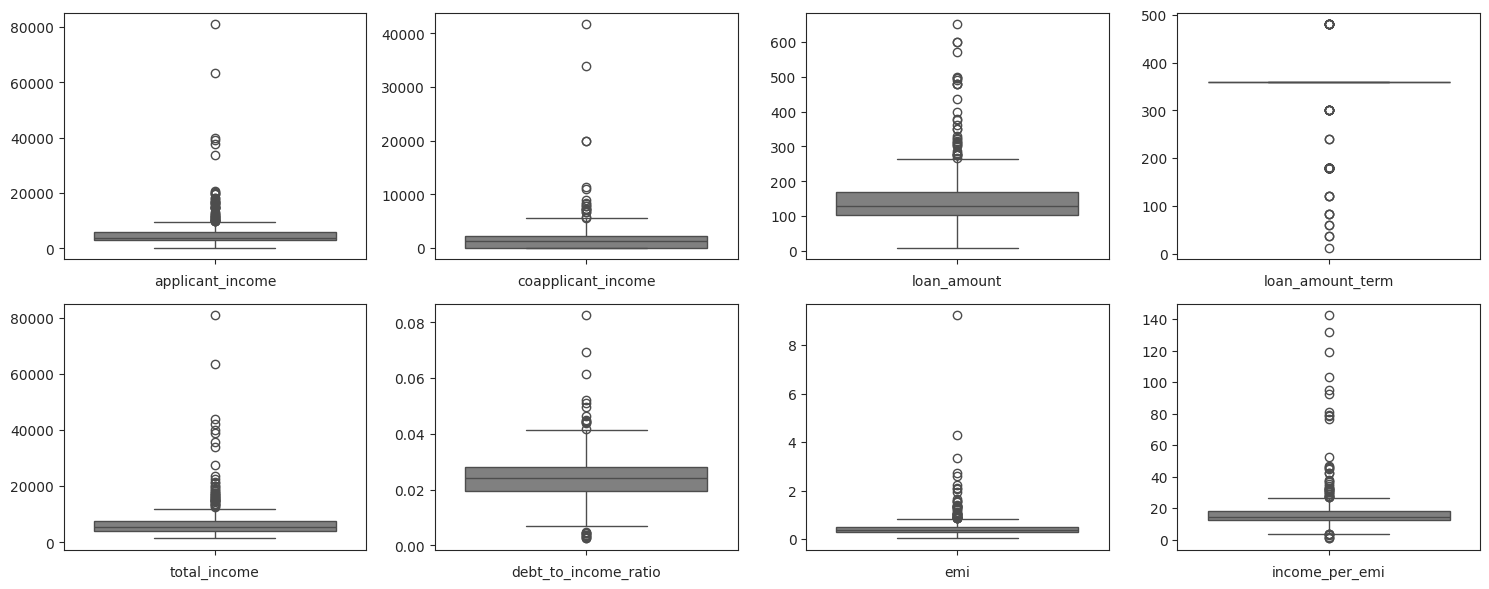

In [24]:
# Let's plot them to and decide how to handle each of them.
fig, axes = plt.subplots(2, 4, figsize=(15, 6))       # axes here is a 2D array.
sns.set_style("ticks")                                # Setting the background style to "darkgrid".
axes = axes.flatten()                                 # By flattening the axes, we convert it in an 1D array such that it can be iterable.
for i, col in enumerate(col_to_cap):                  # enumerate allows us to iterate with i through axes and col through num_columns.
  g = sns.boxplot(                                    # By assigning the plot to a variable(g) we have more control over it.
                   df_wt_na,                          # Passing the dataset.
                   y = col,                           # Passing the column ww want to plot.
                   ax = axes[i],                      # We're asking python to plot the col in the i-th subplot(axes[i])
                   color = "gray",                    # Setting the color to blue.
                  )
  g.set(xlabel=col, ylabel='')                        # Setting the x and y label.
plt.tight_layout()                                    # Adjust layout to prevent label cutoff.
plt.show()                                            # Showing the plot.

In [25]:
def log_cap(df, col_list):
    # Reduce the impact of outliers

    for col in col_list:
        df[col] = np.log1p(df[col])
    return df

In [26]:
# Passing a copy of  in our log_cap function
df_log = log_cap(df_wt_na.copy(), col_to_cap)

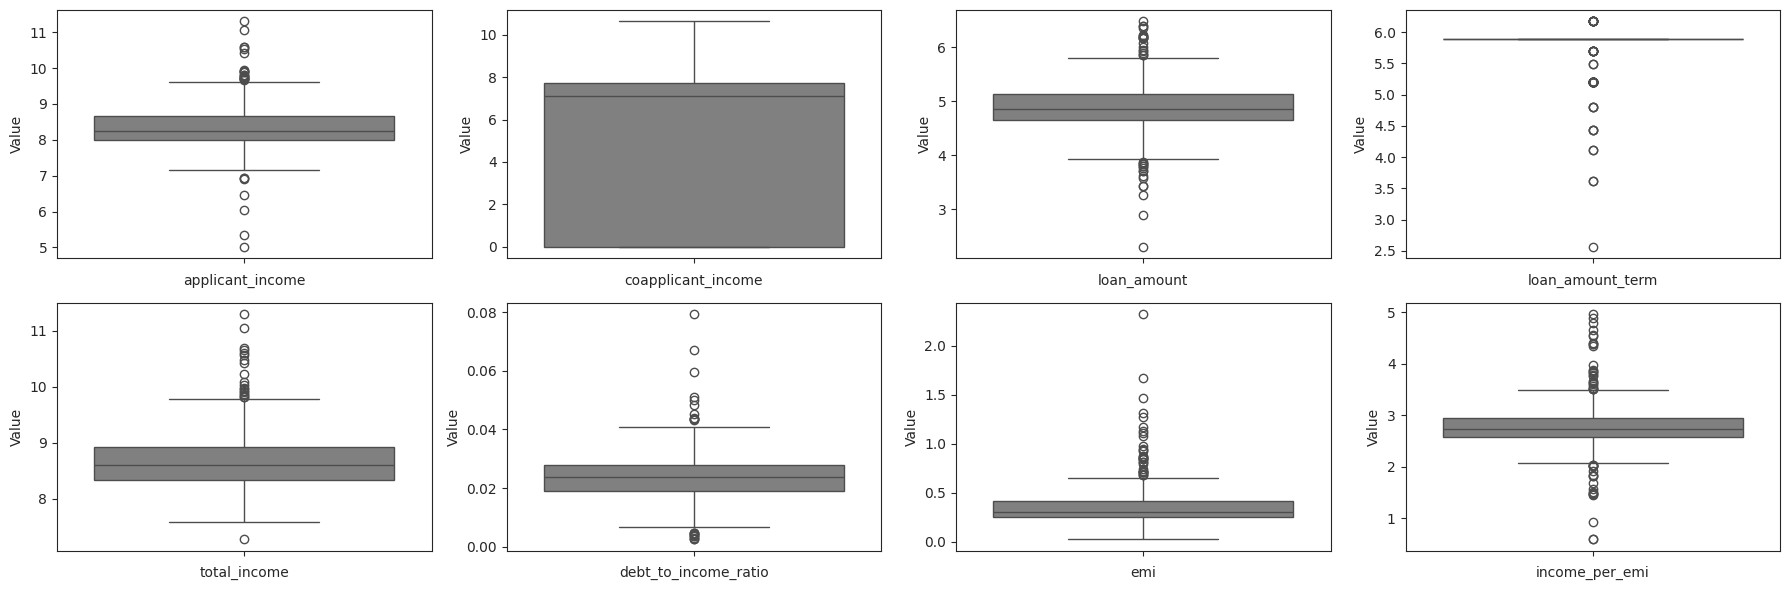

In [27]:
# Let's plot them and decide how to handle each of them.

fig, axes = plt.subplots(2, 4, figsize=(18, 6))         # Create a grid of subplots (2 rows x 4 columns). axes is a 2D array.
sns.set_style("ticks")                                  # Set the visual style of the plots to "ticks" (clean, minimal style).
axes = axes.flatten()                                   # Convert axes from 2D to 1D so we can loop through it easily.
for i, col in enumerate(col_to_cap):                    # Loop through the list of columns and their corresponding subplot index.
    g = sns.boxplot(                                     # Create a boxplot and assign it to variable g for custom formatting.
        data = df_log,                                   # Use the log-transformed DataFrame.
        y = col,                                         # Plot the column `col` on the y-axis.
        ax = axes[i],                                    # Plot this boxplot in the i-th subplot.
        color = "gray"                                   # Set the box color to gray.
    )
    g.set(xlabel=col, ylabel="Value")                   # Set x-axis and y-axis labels for the plot.
plt.tight_layout()                                      # Automatically adjust spacing to avoid overlap.
plt.show()                                              # Display the complete figure with all subplots.

In [28]:
def iqr_cap(df, collist):
    # Loop through each column in the provided list
    for col in collist:
        q1 = df[col].quantile(0.25)             # First quartile (25% percentile)
        q3 = df[col].quantile(0.75)             # Third quartile (75% percentile)
        iqr = q3 - q1                           # Interquartile Range (IQR): Q3 - Q1
        lower_bound = q1 - 1.5 * iqr            # Lower whisker: values below this are considered outliers
        # upper_bound = df[col].quantile(0.99)  # Optional cap at 99th percentile (commented out)

        df[col] = df[col].clip(lower=lower_bound)  # Cap all values below the lower bound to the lower bound

    return df  # Return the modified DataFrame


In [29]:
# Capping the artificial outliers deriving from log_cap
df_iqr = iqr_cap(df_log.copy(), col_to_cap)

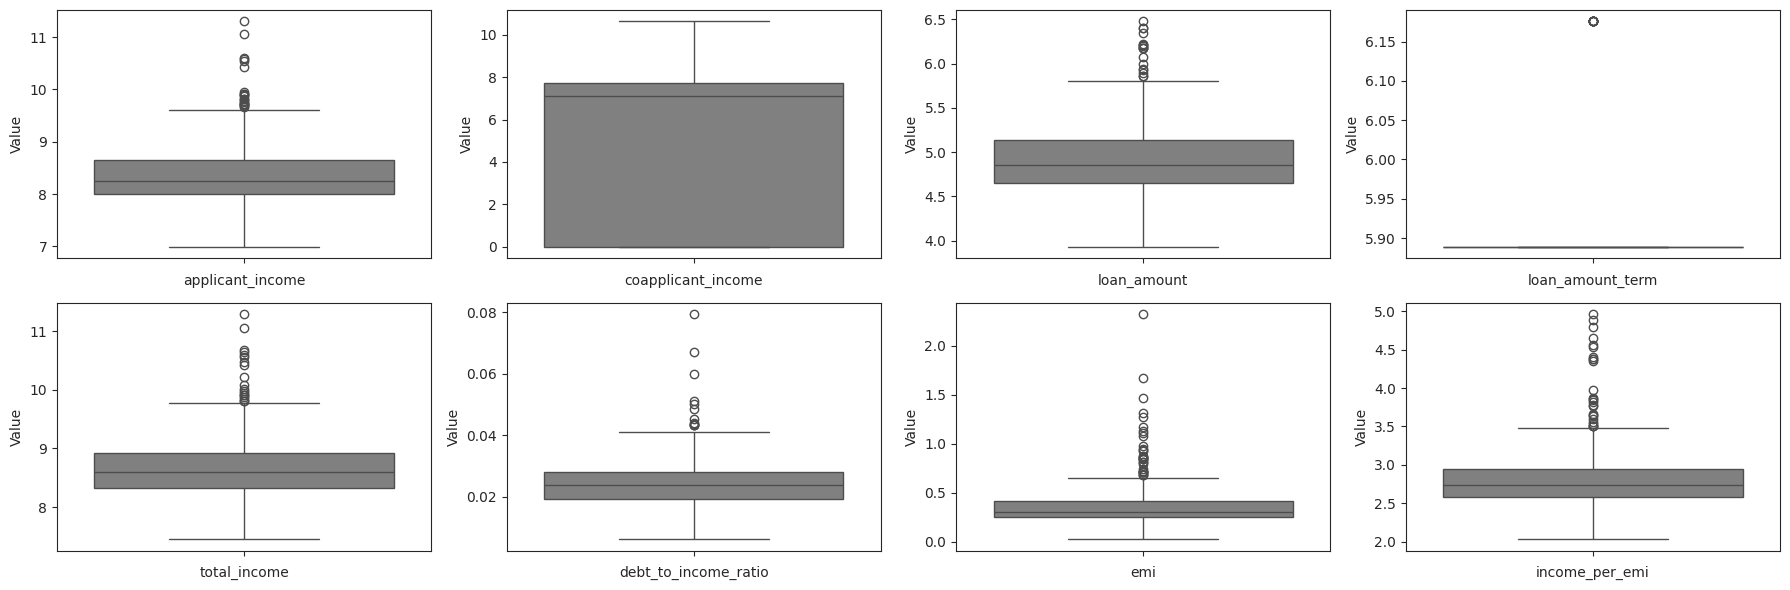

In [30]:
# Let's plot the columns to visually inspect the effect of IQR capping on outliers.
fig, axes = plt.subplots(2, 4, figsize=(18, 6))       # Create a 2x4 grid of subplots with specified size.
sns.set_style("ticks")                                # Use 'ticks' style for cleaner visual presentation.
axes = axes.flatten()                                 # Flatten the 2D array of axes into a 1D array for easy iteration.

for i, col in enumerate(col_to_cap):                  # Loop through each column and its index.
    g = sns.boxplot(                                   # Create a boxplot for the current column.
        data=df_iqr,                                   # Use the DataFrame with IQR-capped values.
        y=col,                                         # Set the column to be plotted on the y-axis.
        ax=axes[i],                                    # Plot in the corresponding subplot.
        color="gray"                                   # Use gray color for boxplots.
    )
    g.set(xlabel=col, ylabel="Value")                 # Label the x-axis with column name, y-axis as "Value".

plt.tight_layout()                                     # Adjust subplot spacing to avoid overlap.
plt.show()                                             # Display the plot.

###**Step 4: Categorical Data Handling.**

In [31]:
display(df_iqr["gender"].unique())          # We have 2 types of gender by now but we can have other types in in th future --> OneHotEncoder.
display(df_iqr["married"].unique())         # We have 2 types of marital status(which is normal). No inerent order amoung them  --> OneHotEncoder.
display(df_iqr["dependents"].unique())      # We clearly have the inerent order here --> LabelEncoder. Since we can not convert it in int.
display(df_iqr["education"].unique())       # Either Graduated or not: LabelEncoder.
display(df_iqr["self_employed"].unique())   # No inerent order amoung them  --> OneHotEncoder.
display(df_iqr["credit_history"].unique())  # No inerent order amoung them  --> OneHotEncoder.
display(df_iqr["property_area"].unique())   # No inerent order amoung them  --> OneHotEncoder.
display(df_iqr["loan_status"].unique())     # No inerent order amoung them but it's the target  --> LabelEncoder.

array(['Male', 'Female'], dtype=object)

array(['Yes', 'No'], dtype=object)

array(['1', '0', '2', '3+'], dtype=object)

array(['Graduate', 'Not Graduate'], dtype=object)

array(['No', 'Yes'], dtype=object)

array([1.0, 0.0], dtype=object)

array(['Rural', 'Urban', 'Semiurban'], dtype=object)

array([0.0, 1.0], dtype=object)

In [32]:
# Define the two lists of cols to encode
col_to_o_h_encode = ["gender", "married", "education", "self_employed", "credit_history", "property_area", "3+_dependents"]
col_to_label_encode = ["dependents", "loan_status"]

In [33]:
# Apply one-hot encoding to selected categorical columns in the DataFrame.
df_encoded = pd.get_dummies(
    df_iqr,                              # The DataFrame to transform (already processed with IQR capping).
    columns=col_to_o_h_encode,           # List of categorical columns to convert to dummy/indicator variables.
    prefix=col_to_o_h_encode,            # Add column name as prefix to new dummy columns.
    dtype=int                            # Ensure new columns use integer type (0 or 1), not boolean or uint8.
)

In [34]:
# Getting the difference in shape between df_iqr and df_encoded.
print(f"difference in number of columns:\n\n\t df_iqr's shape: {df_iqr.shape}\n\n\t df_encoded's shape: {df_encoded.shape}")

difference in number of columns:

	 df_iqr's shape: (512, 17)

	 df_encoded's shape: (512, 24)


In [35]:
# Creating the dictionaries to use for mapping (manual label encoding).
# We're converting text or float labels into clean integers the model can understand.
dependents_dict = {'0': 0, '1': 1, '2': 2, '3+': 3}      # '3+' becomes 3.
loan_status_dict = {0.0: 0, 1.0: 1}                     # Keep loan_status as it is, just to make sure the types match.

# Apply the mapping to the 'dependents' column.
df_encoded["encoded_dependents"] = df_encoded["dependents"].map(dependents_dict)
# Apply the mapping to the 'loan_status' column.
df_encoded["encoded_loan_status"] = df_encoded["loan_status"].map(loan_status_dict)

In [36]:
# Having a look the diff between the orignals and the encoded versions.
# The encoded versions do not have outliers.

df_encoded[["dependents", "encoded_dependents", "encoded_loan_status", "loan_status"]].head()

,dependents,encoded_dependents,encoded_loan_status,loan_status
loan_id,,,,
LP001003,1,1,0,0.0
LP001005,0,0,1,1.0
LP001006,0,0,1,1.0
LP001008,0,0,1,1.0
LP001011,2,2,1,1.0


In [37]:
# Removing the non encoded cols.
df_reshaped = df_encoded.drop(["dependents", "loan_status"], axis = 1)

In [38]:
# Checking that all our features are numerical
len(df_reshaped.columns) - len(df_reshaped.select_dtypes(include = 'number').columns)

0

###**Step5: String Data Handling.**

In [39]:
# NO STRING DATA TO HANDLE.

### **Step 6: Dataset splitting.**

In [40]:
# We're preparing the features (X) and the target (y) for model training.

# X will contain all the columns except the one we're trying to predict.
X = df_reshaped.drop(["encoded_loan_status"], axis=1)       # Drop the target column from the features.

# y is what we want to predict — the "label" or "target".
y = df_reshaped["encoded_loan_status"]                      # This is the column we'll train the model to predict.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(  # Split the features and target into train and test sets.
    X,                                                # The feature variables.
    y,                                                # The target variable.
    stratify = y,                                     # Ensures both sets have the same class distribution.
    random_state = 42,                                # Fixes randomness so the result is reproducible.
    shuffle = True,                                   # Shuffles the data before splitting.
    test_size = 0.2                                   # 20% of the data will be in the test set.
)

### **Step 7: Feature Scaling.**

In [42]:
# Let's see which columns are skewed using the Pearson and D'Agostino normality test.
normal_cols = []     # List to collect columns that look normally distributed.
skewed_cols = []     # List to collect columns that are not normally distributed (i.e., skewed).

def normal_test(df, column_list, alpha=0.05):
    H0 = "The distribution is normal"               # Null hypothesis: the column is normally distributed.
    H1 = "The distribution is not normal"           # Alternative hypothesis: the column is not normally distributed.

    for col in column_list:                         # Iterate through the columns to test.
        stat, p_col = normaltest(df[col])           # Perform the D’Agostino and Pearson’s normality test.

        print(f"\nTest Stat for df[{col}]: {stat:.2f}")  # Print the test statistic (combines skewness + kurtosis).

        if p_col < alpha:                           # If p-value is less than significance level...
            print(f"\033[1m{p_col:.3f} < {alpha} ==> H0 rejected: {H1}\033[0m")
            skewed_cols.append(col)                 # ...it’s not normal, add to skewed_cols.
        else:
            print(f"\033[1m{p_col:.3f} > {alpha} ==> Fail to reject H0: {H0}\033[0m")
            normal_cols.append(col)                 # ...it’s normal, add to normal_cols.


In [43]:
# Calling the normal_test, with df_reshaped and col_to_cap as parameters
normal_test(df_reshaped, col_to_cap)


Test Stat for df[applicant_income]: 103.49
0.000 < 0.05 ==> H0 rejected: The distribution is not normal

Test Stat for df[coapplicant_income]: 2467.14
0.000 < 0.05 ==> H0 rejected: The distribution is not normal

Test Stat for df[loan_amount]: 29.24
0.000 < 0.05 ==> H0 rejected: The distribution is not normal

Test Stat for df[loan_amount_term]: 674.64
0.000 < 0.05 ==> H0 rejected: The distribution is not normal

Test Stat for df[total_income]: 119.24
0.000 < 0.05 ==> H0 rejected: The distribution is not normal

Test Stat for df[debt_to_income_ratio]: 134.20
0.000 < 0.05 ==> H0 rejected: The distribution is not normal

Test Stat for df[emi]: 420.34
0.000 < 0.05 ==> H0 rejected: The distribution is not normal

Test Stat for df[income_per_emi]: 195.09
0.000 < 0.05 ==> H0 rejected: The distribution is not normal


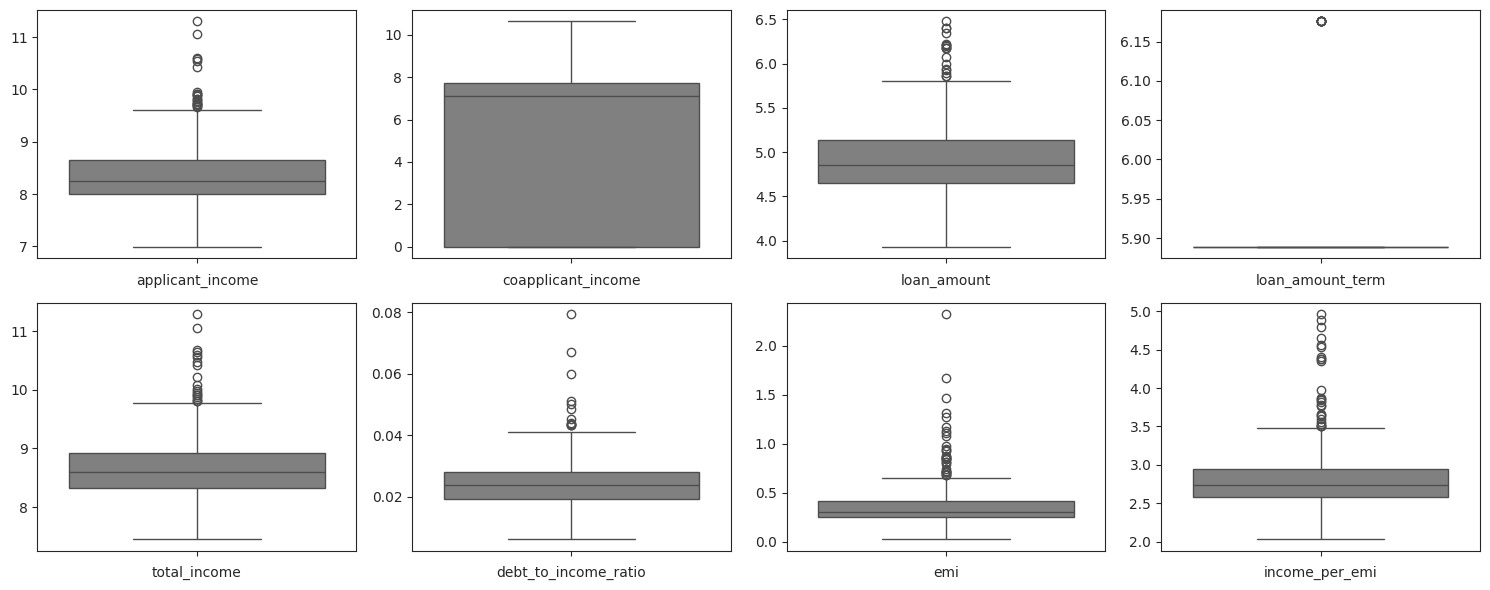

In [44]:
# Let's plot them to and decide how to handle each of them.
fig, axes = plt.subplots(2, 4, figsize=(15, 6))       # axes here is a 2D array.
sns.set_style("ticks")                                # Setting the background style to "darkgrid".
axes = axes.flatten()                                 # By flattening the axes, we convert it in an 1D array such that it can be iterable.
for i, col in enumerate(col_to_cap):                  # enumerate allows us to iterate with i through axes and col through num_columns.
  g = sns.boxplot(                                    # By assigning the plot to a variable(g) we have more control over it.
                   df_reshaped,                       # Passing the dataset.
                   y = col,                           # Passing the column ww want to plot.
                   ax = axes[i],                      # We're asking python to plot the col in the i-th subplot(axes[i])
                   color = "gray",                    # Setting the color to blue.
                  )
  g.set(xlabel=col, ylabel='')                        # Setting the x and y label.
plt.tight_layout()                                    # Adjust layout to prevent label cutoff.
plt.show()                                            # Showing the plot.

In [45]:
# From the Graphical EDA(Boxplot), we can see that except 'num_trips', all the columns have outliers.
'''
Normal dist + no outliers  ===>  StandardScaler
Normal dist + outliers     ===>  StandardScaler or RobustScaler

Skewed dist + no outliers  ===>	 MinMaxScaler
Skewed dist + outliers	   ===>  RobustScaler
'''

'\nNormal dist + no outliers  ===>  StandardScaler\nNormal dist + outliers     ===>  StandardScaler or RobustScaler\n\nSkewed dist + no outliers  ===>\t MinMaxScaler\nSkewed dist + outliers\t   ===>  RobustScaler\n'

In [46]:
# creating the list of skewed distributions which have outliers.
skewed_outliers = [col for col in skewed_cols if col != "coapplicant_income"]

In [47]:
skewed_cols

['applicant_income',
 'coapplicant_income',
 'loan_amount',
 'loan_amount_term',
 'total_income',
 'debt_to_income_ratio',
 'emi',
 'income_per_emi']

In [48]:
# We'll scale in chaine:
rob_scaler = RobustScaler()
mm_scaler = MinMaxScaler()

# 1. Robust(reduice the impact of outliers)
X_train[skewed_outliers] = rob_scaler.fit_transform(X_train[skewed_outliers])
X_test[skewed_outliers] = rob_scaler.transform(X_test[skewed_outliers])

# 2. MinMax(to have all cols in the same scale).
X_train[skewed_cols] = mm_scaler.fit_transform(X_train[skewed_cols])
X_test[skewed_cols] = mm_scaler.transform(X_test[skewed_cols])

# "encoded_dependents" did not need Robustscaler because it didn't have outliers.
X_train["encoded_dependents"] = mm_scaler.fit_transform(X_train[["encoded_dependents"]])
X_test["encoded_dependents"] = mm_scaler.transform(X_test[["encoded_dependents"]])

In [49]:
# checking the scale in X_test
display(X_test.iloc[:,:13].describe()[3::4])
X_test.iloc[:,13:].describe()[3::4]

,applicant_income,coapplicant_income,loan_amount,loan_amount_term,total_income,debt_to_income_ratio,emi,income_per_emi,gender_Female,gender_Male,married_No,married_Yes,education_Graduate
min,0.000000,0.000000,0.000000,0.0,0.033197,0.000000,-0.024630,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.669456,1.019958,0.968647,1.0,0.830103,0.829258,0.706963,0.939661,1.0,1.0,1.0,1.0,1.0


,education_Not Graduate,self_employed_No,self_employed_Yes,credit_history_0.0,credit_history_1.0,property_area_Rural,property_area_Semiurban,property_area_Urban,3+_dependents_Yes,encoded_dependents
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [50]:
# checking the scale in X_train
display(X_train.iloc[:,:13].describe()[3::4])
X_train.iloc[:,13:].describe()[3::4]

,applicant_income,coapplicant_income,loan_amount,loan_amount_term,total_income,debt_to_income_ratio,emi,income_per_emi,gender_Female,gender_Male,married_No,married_Yes,education_Graduate
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,education_Not Graduate,self_employed_No,self_employed_Yes,credit_history_0.0,credit_history_1.0,property_area_Rural,property_area_Semiurban,property_area_Urban,3+_dependents_Yes,encoded_dependents
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [51]:
# checking how balanced or imbalanced our target is.
y.value_counts(normalize = True)*100

,proportion
encoded_loan_status,
1,72.65625
0,27.34375


##**Models:**

###**1. Logistic Regression:**

In [52]:
df_iqr["gender"].value_counts(normalize = True)*100

,proportion
gender,
Male,81.640625
Female,18.359375


In [53]:
# Create a Logistic Regression model instance with a fixed random seed for reproducibility.
lr_model = LogisticRegression(random_state=42)

# Train (fit) the model on the training data (X_train as features, y_train as target labels).
lr_model.fit(X_train, y_train)


LogisticRegression(random_state=42)

In [54]:
# predicting y_test with lr_model.
y_pred_lr = lr_model.predict(X_test)

In [95]:
def model_evaluation(model, y_pred):

    # Get predicted probabilities for positive class (1 --> loan approved)
    y_score = model.predict_proba(X_test)[:, 1]

    # Print the title for the confusion matrix section
    print(f"Confusion_matrix:")

    # Calculate and print the confusion matrix comparing true labels (y_test) with predictions (y_pred)
    # It shows counts of true positives, true negatives, false positives, and false negatives
    print(f"{confusion_matrix(y_test, y_pred)}\n\n")

    # Print the title for the classification report section
    print(f"Classification Report:")

    # Calculate and print detailed classification metrics such as precision, recall, f1-score for each class
    print(f"{classification_report(y_test, y_pred)}")

    # Print the title for the ROC AUC score section
    print(f"roc_auc_score:\n")

    # Calculate and print the ROC AUC score, which measures the model’s ability to distinguish classes
    # (A higher score near 1 means better performance)
    print(f"{roc_auc_score(y_test, y_score):.3f}")

In [56]:
def roc_auc_curve(model):

    # Get predicted probabilities for positive class (1 --> loan approved)
    y_score = model.predict_proba(X_test)[:, 1]

    # Compute the False Positive Rate and True Positive Rate for different thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    # Compute the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)

    # AUC Score (0–1)	Closer to 1 = better. 0.5 = random. < 0.5 = harmful
    # Plot the ROC curve
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})", color="darkorange")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal = random guess
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Receiver Operating Characteristic (ROC) Curve {model}")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [96]:
# lr_model's evaluation
model_evaluation(lr_model, y_pred_lr)

Confusion_matrix:
[[10 18]
 [ 3 72]]


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.36      0.49        28
           1       0.80      0.96      0.87        75

    accuracy                           0.80       103
   macro avg       0.78      0.66      0.68       103
weighted avg       0.79      0.80      0.77       103

roc_auc_score:

0.698


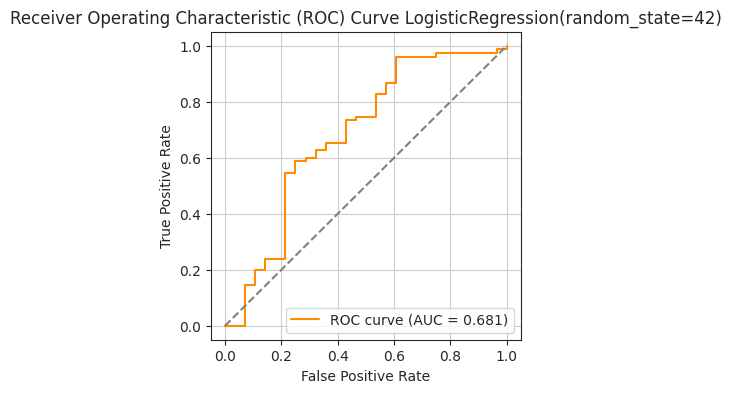

In [58]:
roc_auc_curve(lr_model)

In [59]:
sm = SMOTE(random_state = 42)

In [60]:
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [61]:
sm_lr_model = lr_model = LogisticRegression(random_state = 42)
sm_lr_model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=42)

In [62]:
y_pred_sm_lr = sm_lr_model.predict(X_test)

In [97]:
model_evaluation(sm_lr_model, y_pred_sm_lr)

Confusion_matrix:
[[13 15]
 [13 62]]


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.46      0.48        28
           1       0.81      0.83      0.82        75

    accuracy                           0.73       103
   macro avg       0.65      0.65      0.65       103
weighted avg       0.72      0.73      0.72       103

roc_auc_score:

0.698


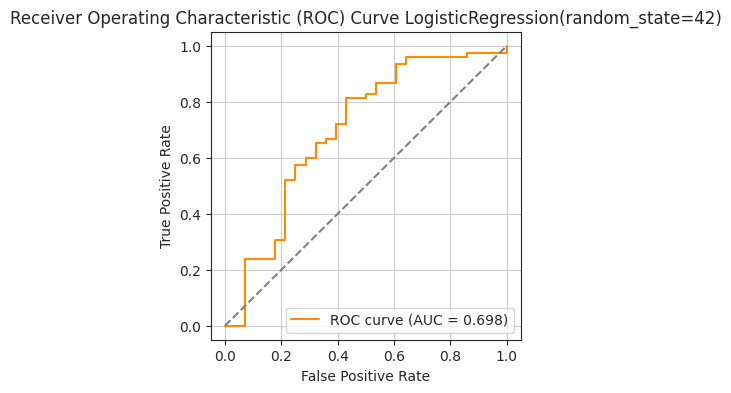

In [64]:
roc_auc_curve(sm_lr_model)

In [65]:
# Hypertunning our lr_model:

# 1. Create a dictionary of hyperparam to test.
param_grid_lr = {
    'C': [0.1, 1, 10],            # Regularization strength. Lower values = stronger penalty
    'penalty': ['l2'],                  # Type of regularization (L2 is standard for logistic regression)
    'solver': ['liblinear', 'saga'],    # Algorithms used to find the best model. These support 'l2'
    'class_weight': [None, 'balanced'],  # Try default vs adjusting for class imbalance
    'max_iter': [100, 500, 1000]
}

# 2.
# - Set up the grid search
# - cv=5: use 5-fold cross-validation to check performance
# - scoring='f1': optional – focus on F1 score if your data is imbalanced
grid = GridSearchCV(lr_model, param_grid_lr, cv = 5, scoring='f1')


# 3. Fit the grid search on training data
grid.fit(X_train, y_train)

# 5. Print the best combination of hyperparameters found
print("Best hyperparameters:", grid.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

Best hyperparameters: {'C': 0.1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [66]:
# 6. Use the best model to predict and evaluate on test data
# best_model = grid.best_estimator_

# Create a Logistic Regression model with specific hyperparameters:
tuned_lr_model = LogisticRegression(
    C=1,                  # Regularization strength; smaller C means stronger regularization (prevents overfitting)
    class_weight=None,    # No adjustment to class weights (all classes treated equally)
    max_iter=100,         # Maximum number of iterations for the solver to converge
    penalty='l2',         # Use L2 regularization (adds a penalty proportional to squared coefficients)
    solver='liblinear',   # Optimization algorithm used to fit the model, good for small datasets
    random_state=42       # Fixed seed for reproducibility of results
)

# Train the Logistic Regression model on the training data (features and labels)
tuned_lr_model.fit(X_train, y_train)



LogisticRegression(C=1, random_state=42, solver='liblinear')

In [67]:
# tuned_lr_model's prediction of y_test.
y_pred_tuned_lr = tuned_lr_model.predict(X_test)

In [94]:
# tuned_lr_model's evaluation.
model_evaluation(tuned_lr_model, y_pred_tuned_lr)

LogisticRegression(C=1, random_state=42, solver='liblinear')


Confusion_matrix:
[[10 18]
 [ 3 72]]


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.36      0.49        28
           1       0.80      0.96      0.87        75

    accuracy                           0.80       103
   macro avg       0.78      0.66      0.68       103
weighted avg       0.79      0.80      0.77       103

roc_auc_score:

0.682


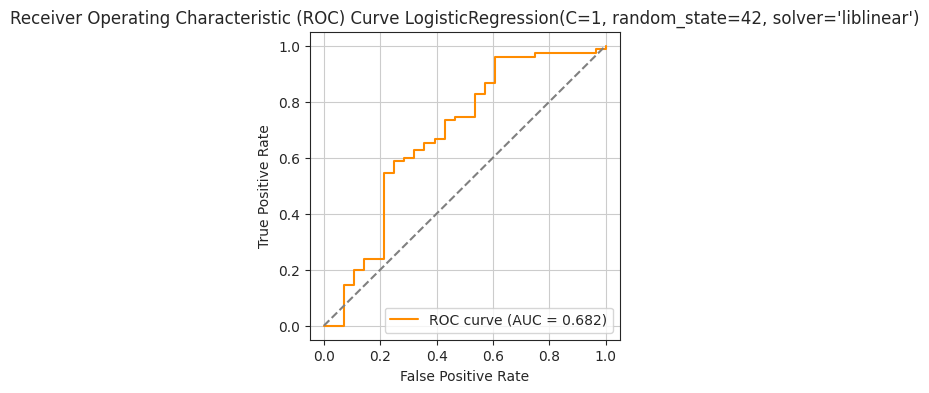

In [69]:
roc_auc_curve(tuned_lr_model)

In [70]:
sm_tuned_lr_model = LogisticRegression(C = 1,
    class_weight = None,
    penalty = 'l2',
    solver = 'liblinear',
    random_state = 42
)
sm_tuned_lr_model.fit(X_resampled, y_resampled)

LogisticRegression(C=1, random_state=42, solver='liblinear')

In [71]:
y_pred_sm_tuned_lr = sm_tuned_lr_model.predict(X_test)

In [72]:
model_evaluation(sm_tuned_lr_model, y_pred_sm_tuned_lr)

Confusion_matrix:
[[15 13]
 [14 61]]


Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.54      0.53        28
           1       0.82      0.81      0.82        75

    accuracy                           0.74       103
   macro avg       0.67      0.67      0.67       103
weighted avg       0.74      0.74      0.74       103

roc_auc_score:

0.702


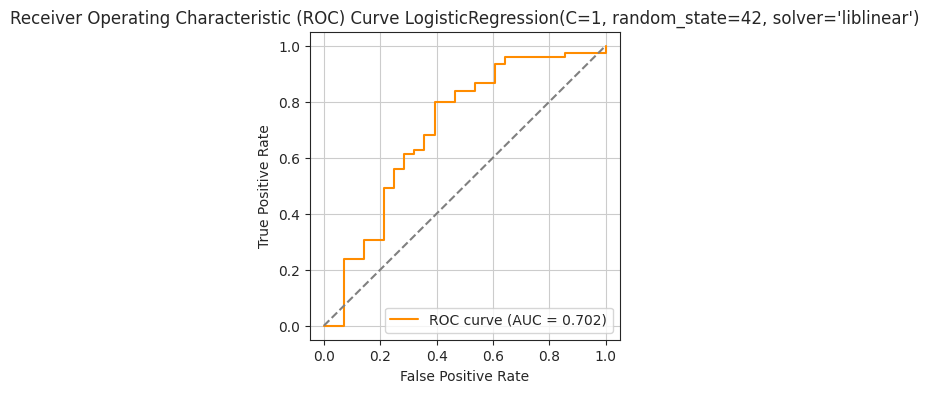

In [73]:
roc_auc_curve(sm_tuned_lr_model)

### **2. Random Forest:**

In [74]:
# Simple random forest.
rf_model = RandomForestClassifier(random_state = 42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [75]:
# Predict y_test with rf_model.
y_pred_rf = rf_model.predict(X_test)

In [76]:
# rf_model's evaluation.
model_evaluation(rf_model, y_pred_rf)

Confusion_matrix:
[[12 16]
 [ 5 70]]


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.43      0.53        28
           1       0.81      0.93      0.87        75

    accuracy                           0.80       103
   macro avg       0.76      0.68      0.70       103
weighted avg       0.78      0.80      0.78       103

roc_auc_score:

0.719


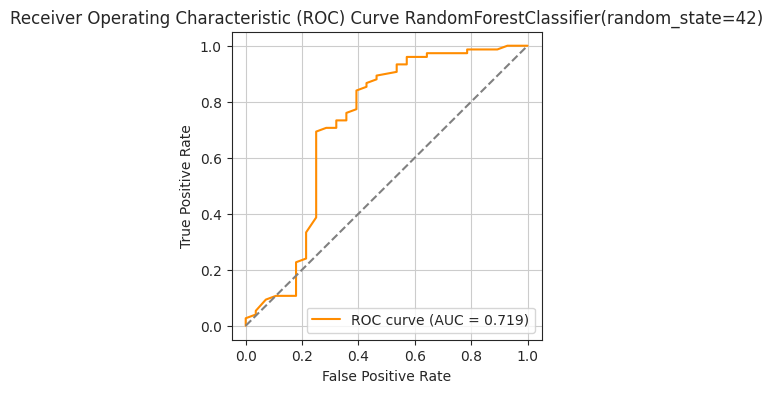

In [77]:
roc_auc_curve(rf_model)

In [78]:
# Simple sm_random forest.
sm_rf_model = RandomForestClassifier(random_state = 42)
sm_rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [79]:
# Predict y_test with rf_model.
y_pred_sm_rf = sm_rf_model.predict(X_test)

In [80]:
# model evaluation
model_evaluation(sm_rf_model, y_pred_sm_rf)

Confusion_matrix:
[[14 14]
 [12 63]]


Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.50      0.52        28
           1       0.82      0.84      0.83        75

    accuracy                           0.75       103
   macro avg       0.68      0.67      0.67       103
weighted avg       0.74      0.75      0.74       103

roc_auc_score:

0.647


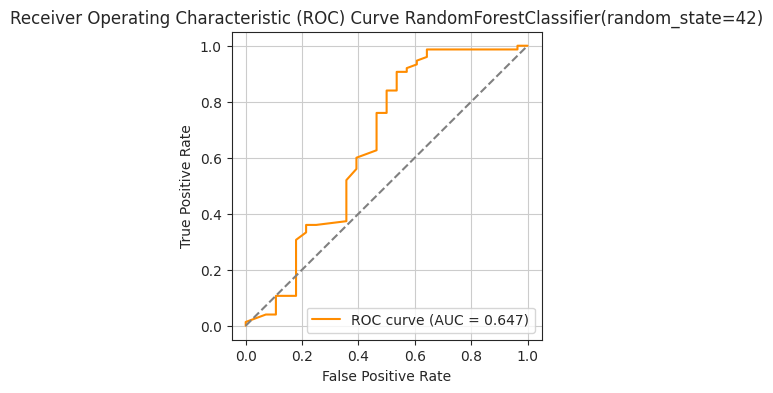

In [81]:
roc_auc_curve(sm_rf_model)

In [82]:
# 1. Defining the parameters for the  grid search.

param_grid_rf = {
    'n_estimators': [5, 10, 20],           # Number of trees in the forest
    'max_depth': [None, 5, 10],               # Max depth of trees
    'min_samples_split': [2, 5, 10],          # Min samples needed to split a node
    'min_samples_leaf': [1, 2, 4],            # Min samples per leaf node
    'bootstrap': [True, False],               # Whether to use bootstrap samples
    'class_weight': ['balanced', None]        # Try to adjust for class imbalance or not.
}


# 2. Wrap in GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=5,                         # 5-fold cross-validation
    scoring='f1',                 # Optimize for F1-score
    n_jobs=-1,                    # Use all processors
    verbose=1                     # Show progress
)

# 4. Fit on training data
grid_search.fit(X_train, y_train)

# 5. Get the best model
best_rf = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'bootstrap': True, 'class_weight': None, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}


In [83]:
# Create a tuned Random Forest classifier with specific hyperparameters:
tuned_rf_model = RandomForestClassifier(
    bootstrap=True,         # Use bootstrap samples (random subsets with replacement) to build each tree
    class_weight=None,      # No special weighting for classes, treat all equally
    max_depth=5,            # Maximum depth of each decision tree (limits tree size to avoid overfitting)
    min_samples_leaf=1,     # Minimum number of samples required at a leaf node (end of a branch)
    min_samples_split=10,   # Minimum samples needed to split an internal node (higher value = less splits)
    n_estimators=20,        # Number of trees in the forest (more trees = usually better, but slower)
    random_state=42         # Fix the random seed to make results reproducible
)

# Train the Random Forest model on the training data
tuned_rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=20,
                       random_state=42)

In [84]:
# tuned_rf_model's evaluation
y_pred_tuned_rf = tuned_rf_model.predict(X_test)

In [85]:
# tuned_rf_model's evaluation:
model_evaluation(tuned_rf_model, y_pred_tuned_rf)

Confusion_matrix:
[[11 17]
 [ 2 73]]


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.39      0.54        28
           1       0.81      0.97      0.88        75

    accuracy                           0.82       103
   macro avg       0.83      0.68      0.71       103
weighted avg       0.82      0.82      0.79       103

roc_auc_score:

0.699


In [86]:
sm_tuned_rf_model = RandomForestClassifier(
    bootstrap = True,
    class_weight = None,
    max_depth = None,
    min_samples_leaf = 1,
    min_samples_split = 10,
    n_estimators = 20,
    random_state = 42
)
sm_tuned_rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(min_samples_split=10, n_estimators=20, random_state=42)

In [87]:
y_pred_sm_tuned_rf = sm_tuned_rf_model.predict(X_test)

In [88]:
model_evaluation(sm_tuned_rf_model, y_pred_sm_tuned_rf)

Confusion_matrix:
[[15 13]
 [13 62]]


Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.54      0.54        28
           1       0.83      0.83      0.83        75

    accuracy                           0.75       103
   macro avg       0.68      0.68      0.68       103
weighted avg       0.75      0.75      0.75       103

roc_auc_score:

0.649


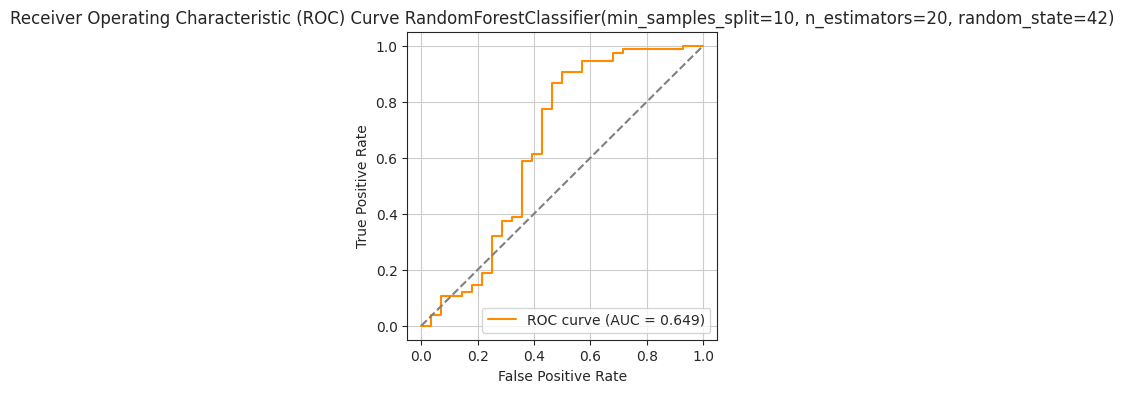

In [89]:
roc_auc_curve(sm_tuned_rf_model)

##**FINAL CHOICE OF MODEL:**

In [90]:
# rf_model is the better choice.
# It has higher accuracy, better class balance, and overall more reliable performance, despite slightly lower AUC.